In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow as tf
import logging
# tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# set random seed
seed(10)
# set_random_seed(10)

In [2]:
df = pd.read_csv('data/NYT.csv', index_col=0)
df_ano = pd.read_csv('data/NYT_ano.csv', index_col=0)

# train = df - df_ano

# test = df

# 데이터 jump 오류 있음
timestamp 에서 중간에 1800 기준으로 나타나지 않는 구간이 생기다 보니 문제가 생김
데이터 수에서도 문제가 생기기 때문에 이를 수정해줘서 데이터를 맞춰줌


In [3]:
st = df['timestamp'][0]
new_timestamp = list()
for i in range(len(df['timestamp'])):
    new_timestamp.append(st)
    st +=1800
df['new_timestamp'] = new_timestamp
df.head()

,timestamp,value,new_timestamp
0,1404165600,10844.0,1404165600
1,1404167400,8127.0,1404167400
2,1404169200,6210.0,1404169200
3,1404171000,4656.0,1404171000
4,1404172800,3820.0,1404172800


In [4]:
new_start = list()
new_end = list()
for i in range(len(df_ano)):
    st_df = df.loc[df['timestamp'] == df_ano['start'][i]]
    ed_ef = df.loc[df['timestamp'] == df_ano['end'][i]]
    new_start.append(int(st_df['new_timestamp']))
    new_end.append(int(ed_ef['new_timestamp']))

df_ano['new_start'] = new_start
df_ano['new_end'] = new_end
df_ano
del df['timestamp']
del df_ano['start']
del df_ano['end']
    

In [13]:
df_ano

,new_start,new_end
0,1414675800,1415046600
1,1416909600,1417280400
2,1419327000,1419697800
3,1419881400,1420252200
4,1422124200,1422495000


In [6]:
# tr_con1 = df['new_timestamp'] < df_ano['new_start'][0]
# tr_con2 = df['new_timestamp'] < df_ano['new_start'][1]
# tr_con2_1 =df['new_timestamp'] > df_ano['new_end'][0]
# train_df2 = df[tr_con2&tr_con2_1]
# train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034 entries, 6046 to 7079
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      1034 non-null   int64  
 1   value          1034 non-null   float64
 2   new_timestamp  1034 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 32.3 KB


In [5]:
tr_con1 = df['new_timestamp'] < df_ano['new_start'][0]
train_df1 = df[tr_con1]
tr_con2 = df['new_timestamp'] < df_ano['new_start'][1] 
tr_con2_1 = df['new_timestamp'] > df_ano['new_end'][0]
train_df2 = df[tr_con2&tr_con2_1]
tr_con3 = df['new_timestamp'] < df_ano['new_start'][2] 
tr_con3_1 = df['new_timestamp'] > df_ano['new_end'][1]
train_df3 = df[tr_con3&tr_con3_1]
tr_con4 = df['new_timestamp'] < df_ano['new_start'][3] 
tr_con4_1 = df['new_timestamp'] > df_ano['new_end'][2]
train_df4 = df[tr_con4&tr_con4_1]
tr_con5 = df['new_timestamp'] < df_ano['new_start'][4] 
tr_con5_1 = df['new_timestamp'] > df_ano['new_end'][3]
train_df5 = df[tr_con5&tr_con5_1]
tr_con6 = df['new_timestamp'] > df_ano['new_end'][4]
train_df6 = df[tr_con6]
#########################################
tt_con1 = df['new_timestamp'] >= df_ano['new_start'][0]
tt_con1_1 = df['new_timestamp'] <= df_ano['new_end'][0]
test_df1 = df[tt_con1&tt_con1_1]

tt_con2 = df['new_timestamp'] >= df_ano['new_start'][1]
tt_con2_1 = df['new_timestamp'] <= df_ano['new_end'][1]
test_df2 = df[tt_con2&tt_con2_1]

tt_con3 = df['new_timestamp'] >= df_ano['new_start'][2]
tt_con3_1 = df['new_timestamp'] <= df_ano['new_end'][2]
test_df3 = df[tt_con3&tt_con3_1]

tt_con4 = df['new_timestamp'] >= df_ano['new_start'][3]
tt_con4_1 = df['new_timestamp'] <= df_ano['new_end'][3]
test_df4 = df[tt_con4&tt_con4_1]

tt_con5 = df['new_timestamp'] >= df_ano['new_start'][4]
tt_con5_1 = df['new_timestamp'] <= df_ano['new_end'][4]
test_df5 = df[tt_con5&tt_con5_1]

train_df = pd.concat([train_df1, train_df2, train_df3, train_df4, train_df5, train_df6])
test_df = pd.concat([test_df1, test_df2, test_df3,test_df4,test_df5])

# timestamp를 실제 시간으로 변환

In [6]:
from datetime import datetime
def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

new_time = convert_date(df['new_timestamp'])
df.index = new_time

new_time_train = convert_date(train_df['new_timestamp'])
train_df.index = new_time_train
del train_df['new_timestamp']


In [7]:
# del train_df['new_timestamp']
train_df.head()

,value
2014-07-01 07:00:00,10844.0
2014-07-01 07:30:00,8127.0
2014-07-01 08:00:00,6210.0
2014-07-01 08:30:00,4656.0
2014-07-01 09:00:00,3820.0


In [40]:
# for i in range(len(df_ano)):
#     if i == 0:
#         test_df = df[datetime.fromtimestamp(df_ano['new_start'][i]) : datetime.fromtimestamp(df_ano['new_end'][i])]
#     else:
#         drops = df[datetime.fromtimestamp(df_ano['new_start'][i]) : datetime.fromtimestamp(df_ano['new_end'][i])]
#         # train_df.drop(drops)
#         test_df = pd.concat([test_df,drops])

# del test_df['new_timestamp']
# test_df.head()

,value
2014-10-30 22:30:00,16749.0
2014-10-30 23:00:00,14604.0
2014-10-30 23:30:00,13367.0
2014-10-31 00:00:00,16382.0
2014-10-31 00:30:00,19879.0


# 전처리

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df)
# X_test = scaler.transform(test_df)

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# print("Test data shape:", X_test.shape)

Training data shape: (9285, 1, 1)


# 모델 준비

In [9]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

# fit the model to the data
nb_epochs = 50
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              17    

# 결과 확인

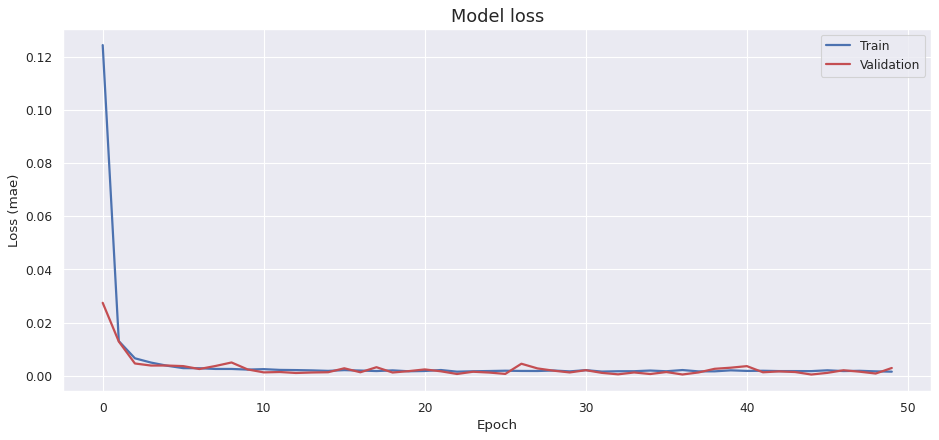

In [10]:
#모델 저장
model.save('/home/rain/anomaly_detection/NYT/result/LSTM_AE_50ep.h5')

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


<AxesSubplot:>

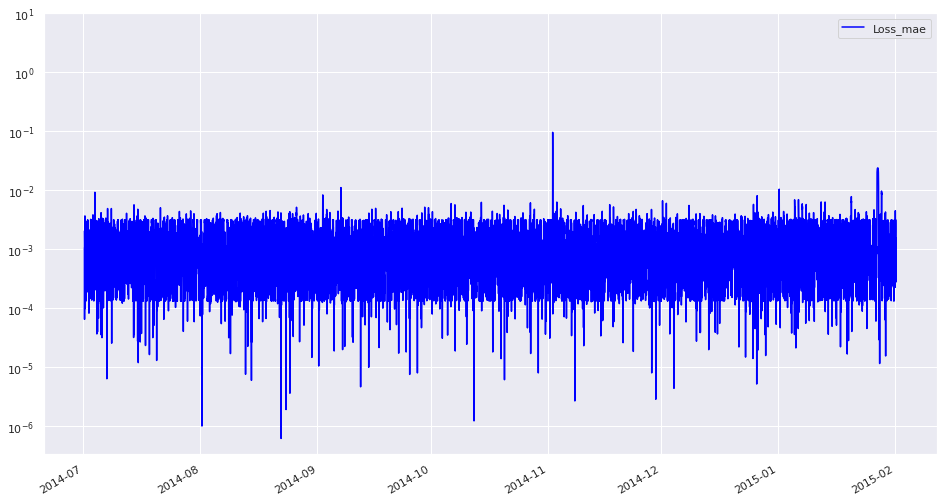

In [61]:
# scored_train = pd.DataFrame(index=train_df.index)
# X_pred_train = model.predict(X_train)
# X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
# Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
# scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)

# scored_test = pd.DataFrame(index=test_df.index)
# X_pred_test = model.predict(X_test)
# X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
# Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
# scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-Xtest), axis = 1)

# scored = pd.concat([scored_train, scored_test])

# scored.plot(logy=True,  figsize=(16,9), ylim=[-1e-2,1e1], color=['blue','red'])

In [11]:
All = df.copy()
# All.head()
del All['new_timestamp']
# All.head()
df.head()
X = scaler.fit_transform(All)
X = X.reshape(X.shape[0], 1, X.shape[1])

X_pred = model.predict(X)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X = X.reshape(X.shape[0], X.shape[2])

comp_all = pd.DataFrame(index=All.index)
comp_all['ori'] = X
comp_all['reconstrtuct'] = X_pred
comp_all['error_mae'] = np.mean(np.abs(X_pred-X), axis = 1)
comp_all.to_csv('/home/rain/anomaly_detection/NYT/result/LSTM_AE_50ep.csv')

50 epoch 그림

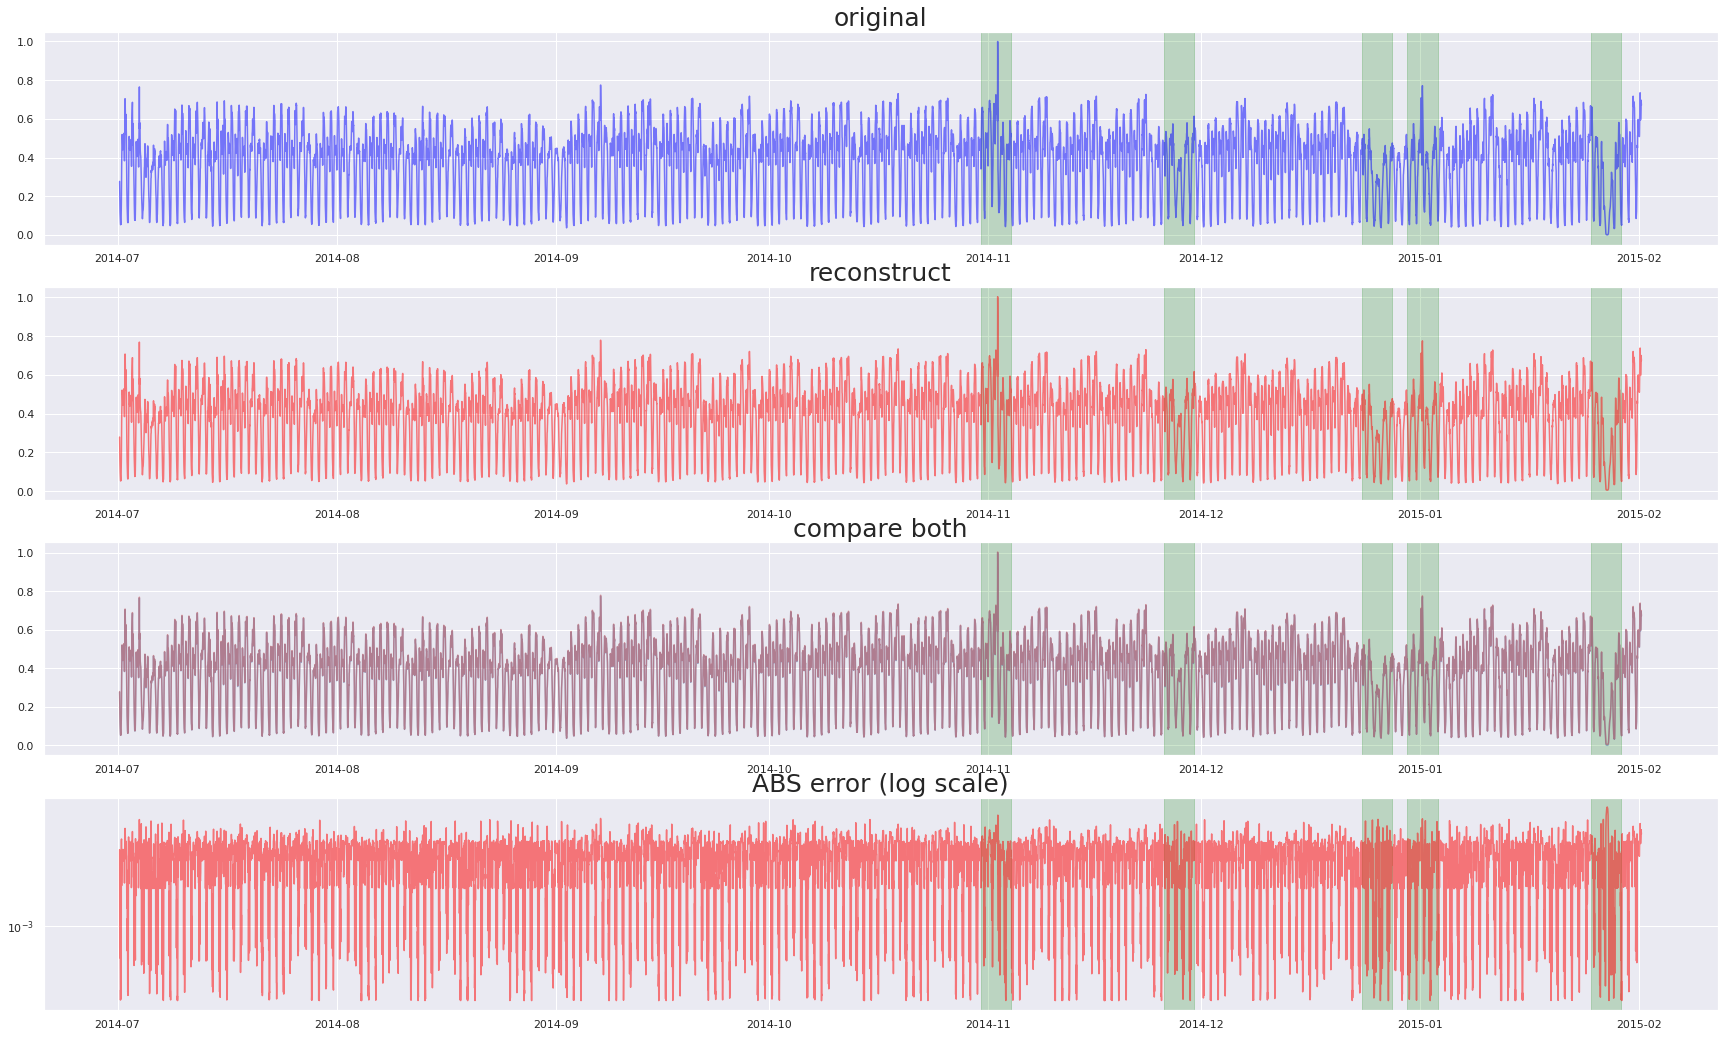

In [12]:
plt.figure(figsize = (30, 18))
# plt.ylim(-1,1)
plt.subplot(4,1,1)
plt.title('original', size=25)
plt.plot(All.index, X, alpha=0.5, color='blue')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,2)
plt.title('reconstruct', size=25)
plt.plot(All.index, X_pred, alpha=0.5, color='red')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)


plt.subplot(4,1,3)
plt.plot(All.index, X, 'b', All.index, X_pred, 'r', alpha=0.5)
plt.title('compare both', size=25)
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,4)
plt.title('ABS error (log scale)', size=25)
plt.plot(All.index, comp_all['error_mae'], alpha=0.5, color='red')
plt.yscale('log')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

30 epoch 그림

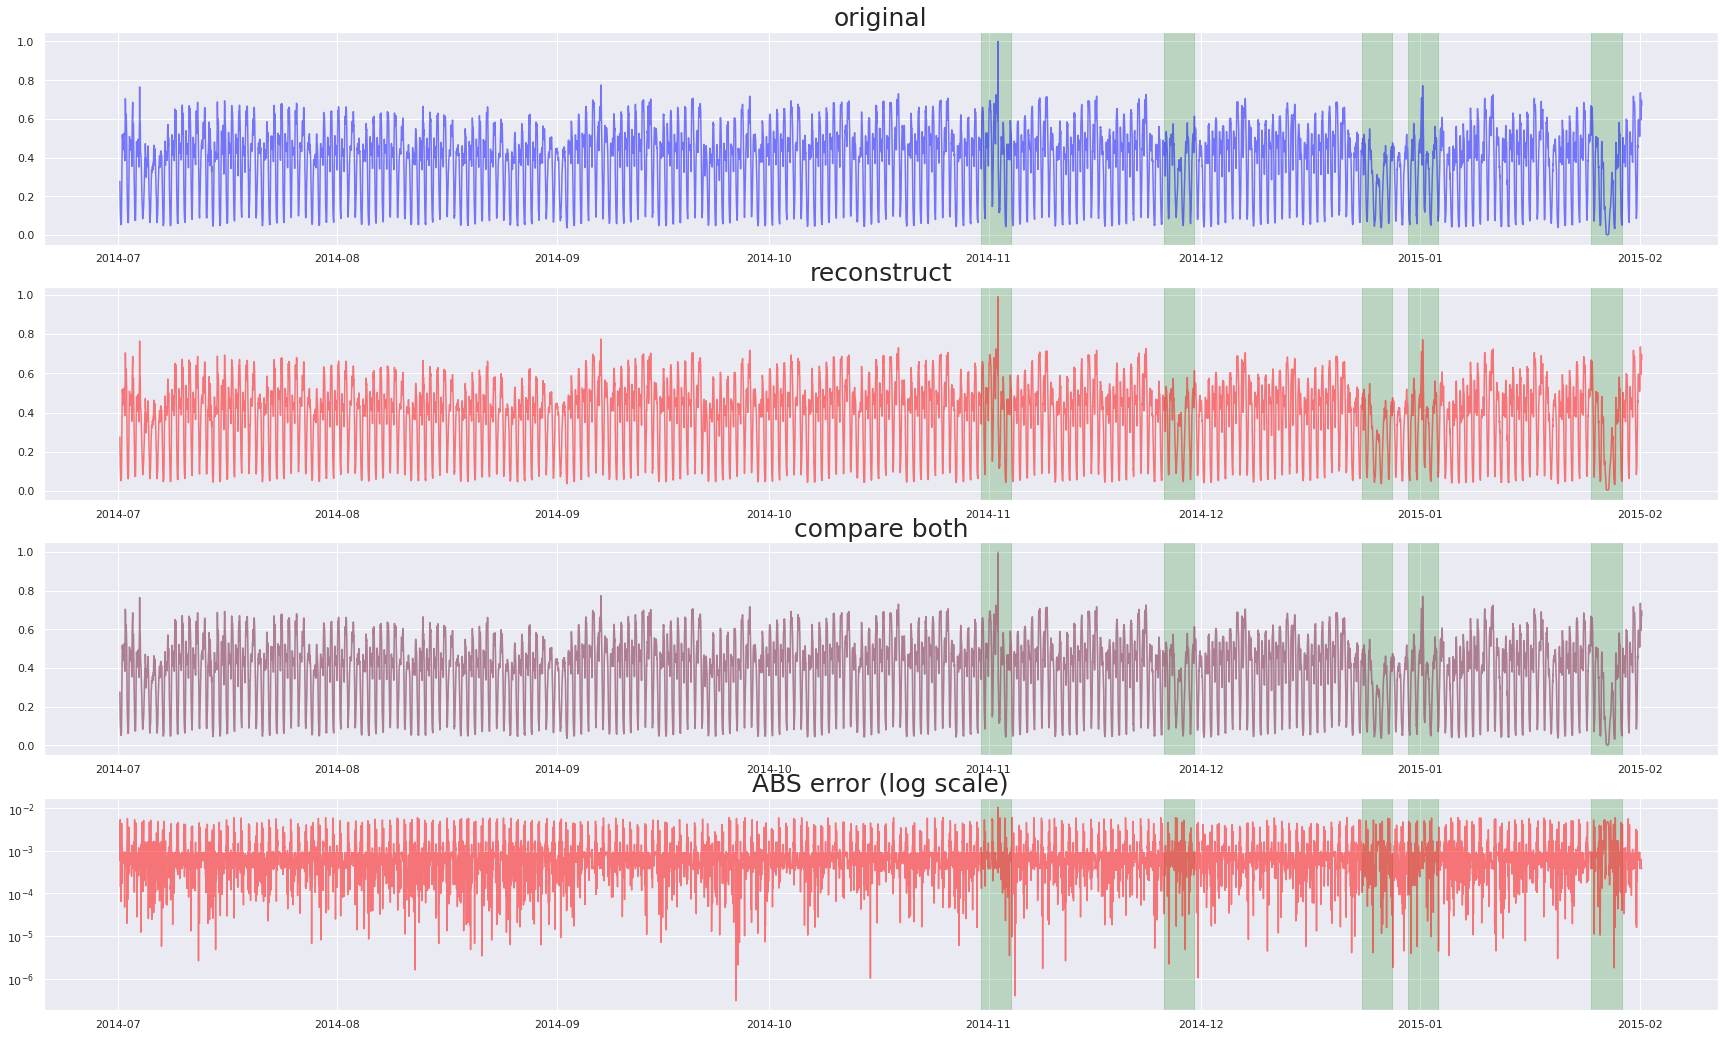

In [14]:
plt.figure(figsize = (30, 18))
# plt.ylim(-1,1)
plt.subplot(4,1,1)
plt.title('original', size=25)
plt.plot(All.index, X, alpha=0.5, color='blue')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,2)
plt.title('reconstruct', size=25)
plt.plot(All.index, X_pred, alpha=0.5, color='red')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)


plt.subplot(4,1,3)
plt.plot(All.index, X, 'b', All.index, X_pred, 'r', alpha=0.5)
plt.title('compare both', size=25)
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,4)
plt.title('ABS error (log scale)', size=25)
plt.plot(All.index, comp_all['error_mae'], alpha=0.5, color='red')
plt.yscale('log')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

10 epoch 그림

/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


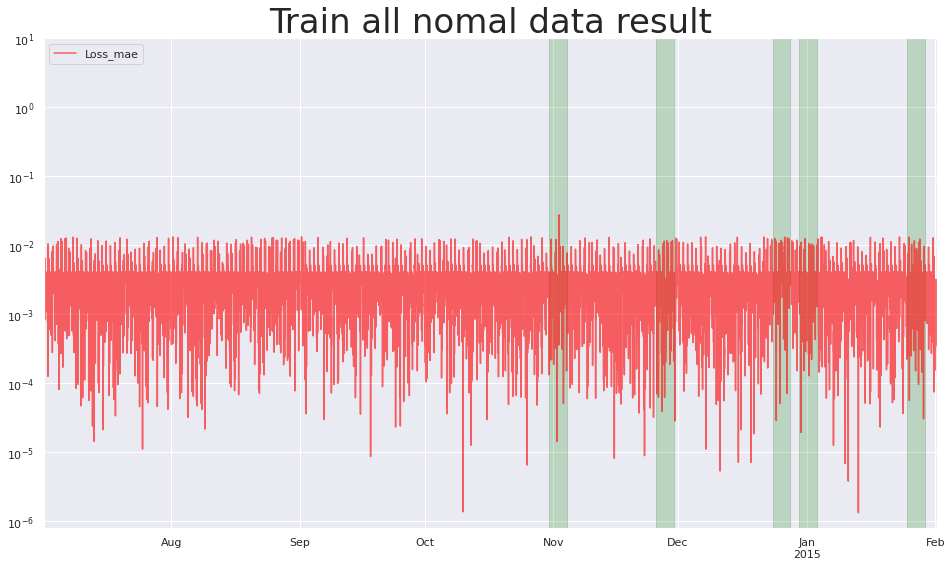

In [45]:
comp_ori = pd.DataFrame(index=All.index)
comp_ori['ori'] = X
comp_recon = pd.DataFrame(index=All.index)
comp_recon['reconstrtuct'] = X_pred_all
comp_all = pd.DataFrame(index=All.index)
comp_all['ori'] = X
comp_all['reconstrtuct'] = X_pred_all

# plt.title('Compare original and reconstruct', size=34)

# comp_ori.plot(logy=True,  figsize=(16,9), ylim=[-1e-2,1e1], alpha=0.6, color='blue')
# plt.subplot(3,1,1)
plt.figure(figsize = (30, 18))
# plt.ylim(-1,1)
plt.subplot(4,1,1)
plt.title('original', size=25)
plt.plot(All.index, X, alpha=0.5, color='blue')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,2)
plt.title('reconstruct', size=25)
plt.plot(All.index, X_pred_all, alpha=0.5, color='red')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)


plt.subplot(4,1,3)
plt.plot(All.index, X, 'b', All.index, X_pred_all, 'r', alpha=0.5)
plt.title('compare both', size=25)
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,4)
plt.title('ABS error (log scale)', size=25)
plt.plot(All.index, scored_all['Loss_mae'], alpha=0.5, color='red')
plt.yscale('log')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

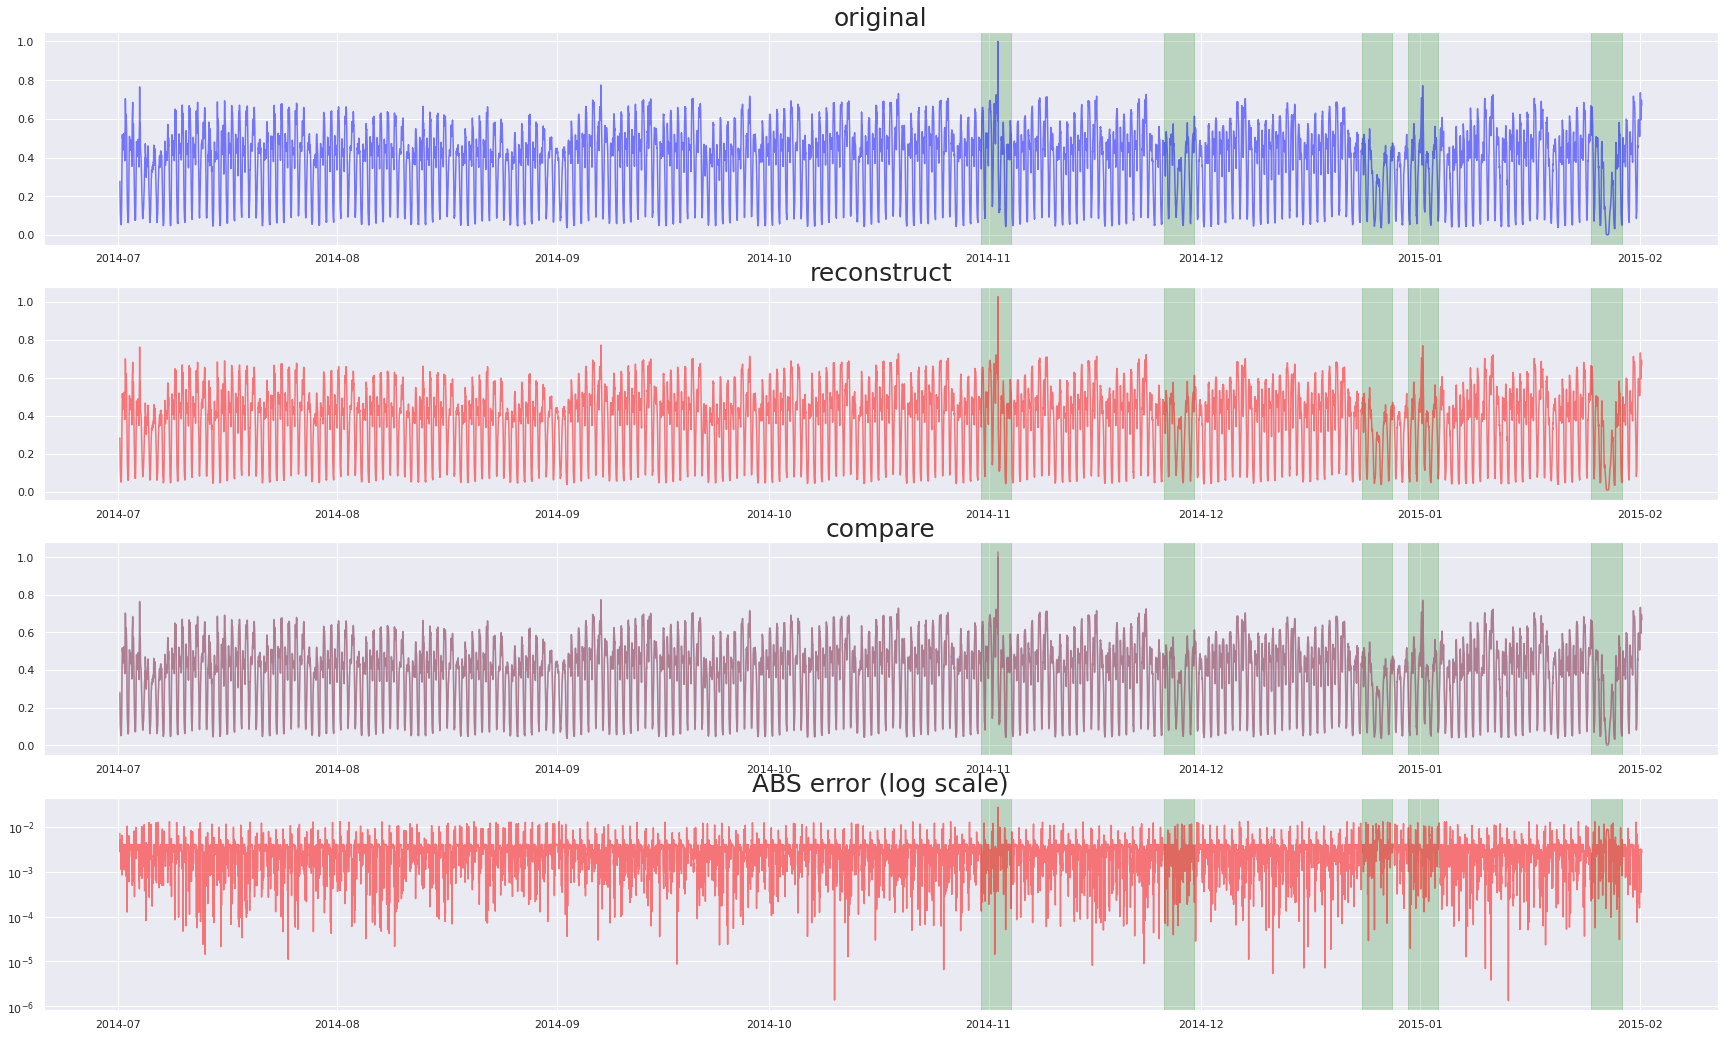

In [82]:
comp_ori = pd.DataFrame(index=All.index)
comp_ori['ori'] = X
comp_recon = pd.DataFrame(index=All.index)
comp_recon['reconstrtuct'] = X_pred_all
comp_all = pd.DataFrame(index=All.index)
comp_all['ori'] = X
comp_all['reconstrtuct'] = X_pred_all

# plt.title('Compare original and reconstruct', size=34)

# comp_ori.plot(logy=True,  figsize=(16,9), ylim=[-1e-2,1e1], alpha=0.6, color='blue')
# plt.subplot(3,1,1)
plt.figure(figsize = (30, 18))
# plt.ylim(-1,1)
plt.subplot(4,1,1)
plt.title('original', size=25)
plt.plot(All.index, X, alpha=0.5, color='blue')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,2)
plt.title('reconstruct', size=25)
plt.plot(All.index, X_pred_all, alpha=0.5, color='red')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)


plt.subplot(4,1,3)
plt.plot(All.index, X, 'b', All.index, X_pred_all, 'r', alpha=0.5)
plt.title('compare both', size=25)
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,4)
plt.title('ABS error (log scale)', size=25)
plt.plot(All.index, scored_all['Loss_mae'], alpha=0.5, color='red')
plt.yscale('log')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

In [68]:
comp_all.head()
comp_all.to_csv('/home/rain/anomaly_detection/NYT/result/LSTM_AE.csv')

/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


<AxesSubplot:>

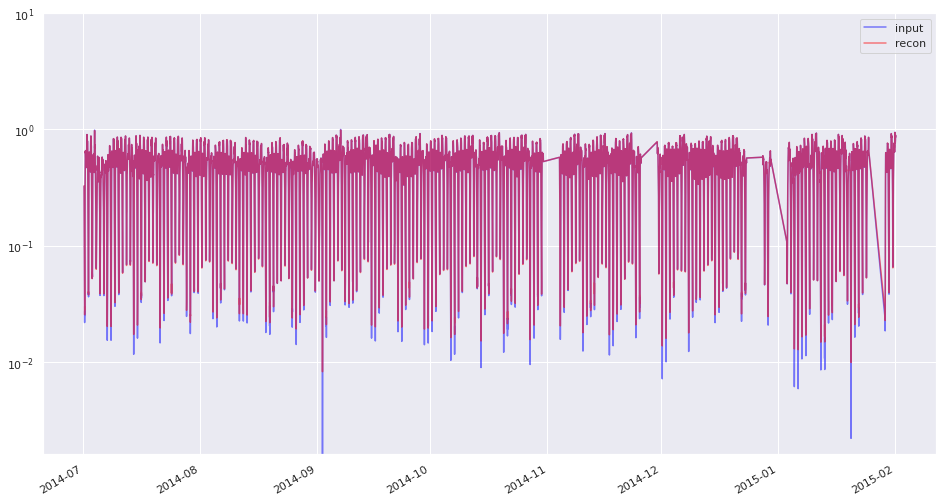

In [75]:
recon_train = pd.DataFrame(index = df.index)
recon_train['input'] = Xtrain
recon_train['recon'] = X_pred_train
recon_train.plot(logy=True,  figsize=(16,9), alpha = 0.5, ylim=[-1e-2,1e1], color=['blue','red'])


/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


<AxesSubplot:>

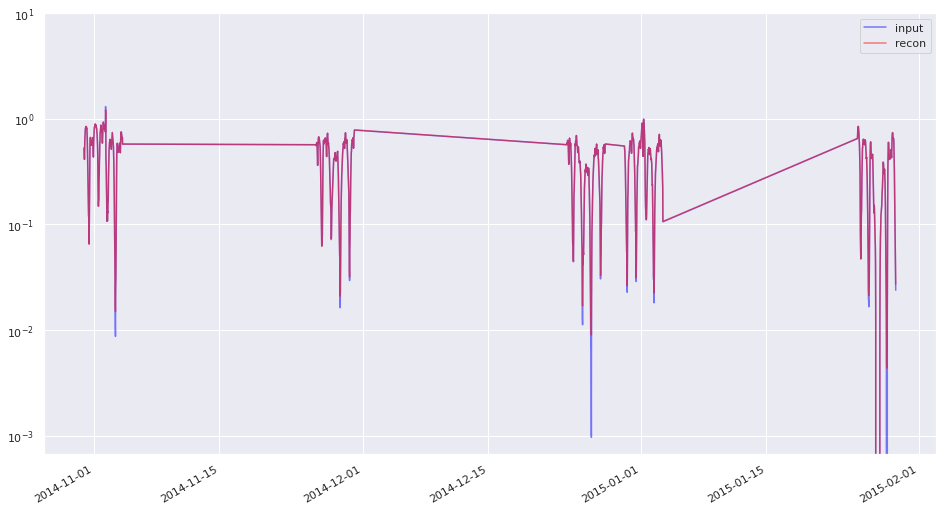

In [76]:
recon_test = pd.DataFrame(index = test_df.index)
recon_test['input'] = Xtest
recon_test['recon'] = X_pred_test
recon_test.plot(logy=True,  figsize=(16,9), alpha = 0.5, ylim=[-1e-2,1e1], color=['blue','red'])

/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


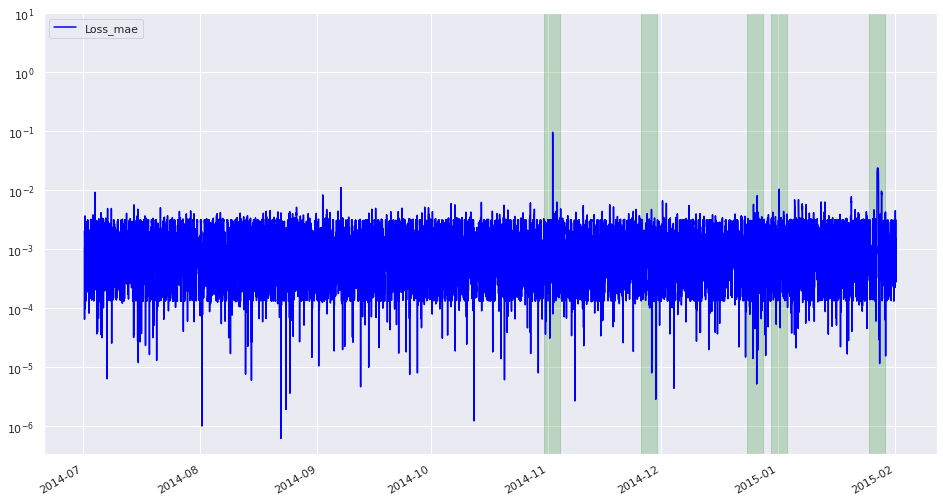

In [66]:
scored.plot(logy=True,  figsize=(16,9), ylim=[-1e-2,1e1], color=['blue','red'])
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 07:00:00 to 2015-02-01 06:30:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   value          10320 non-null  float64
 1   new_timestamp  10320 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 561.9 KB


In [62]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10330 entries, 2014-07-01 07:00:00 to 2015-01-29 10:30:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Loss_mae  10330 non-null  float64
dtypes: float64(1)
memory usage: 161.4 KB


/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-0.05, 0.05)

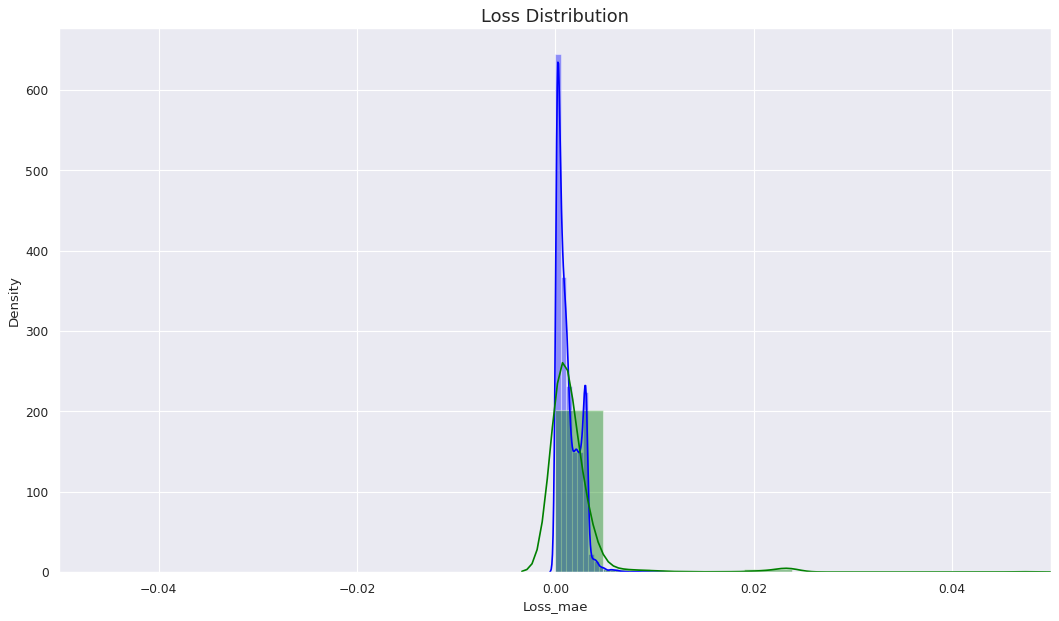

In [60]:


plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored_train['Loss_mae'], bins = 20, kde= True, color = 'blue')
sns.distplot(scored_test['Loss_mae'], bins = 20, kde= True, color = 'green')
plt.xlim([-0.05,0.05])

In [81]:
all_df = df


,value,new_timestamp
2014-07-01 07:00:00,10844.0,1404165600
2014-07-01 07:30:00,8127.0,1404167400
2014-07-01 08:00:00,6210.0,1404169200
2014-07-01 08:30:00,4656.0,1404171000
2014-07-01 09:00:00,3820.0,1404172800


/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


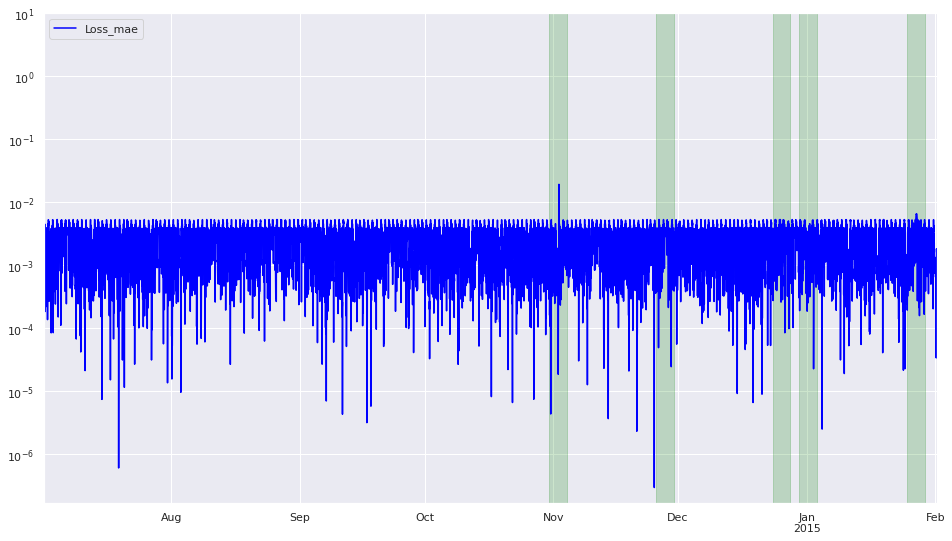

In [82]:
all_df = df
del all_df['new_timestamp']
X = scaler.fit_transform(all_df)
X = X.reshape(X.shape[0], 1, X.shape[1])

X_pred = model.predict(X)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X = X.reshape(X.shape[0], X.shape[2])
scored_all = pd.DataFrame(index = all_df.index)
scored_all['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)

scored_all.plot(logy=True,  figsize=(16,9), ylim=[-1e-2,1e1], color=['blue','red'])
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)


/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempte

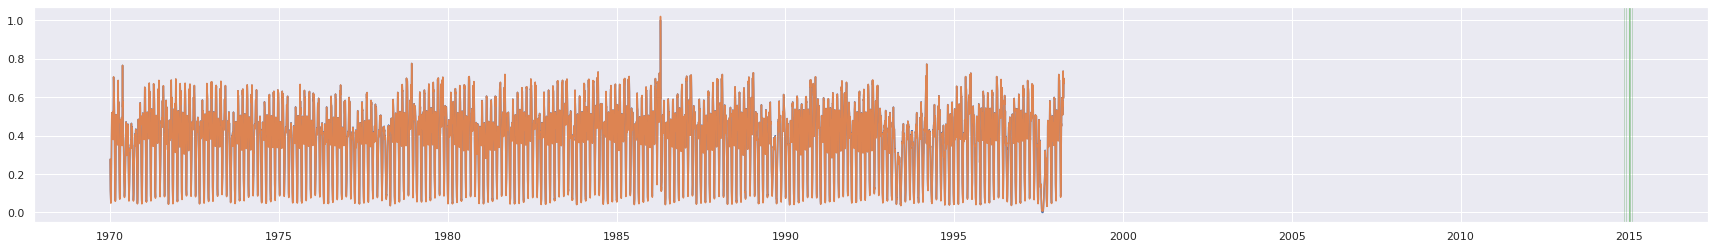

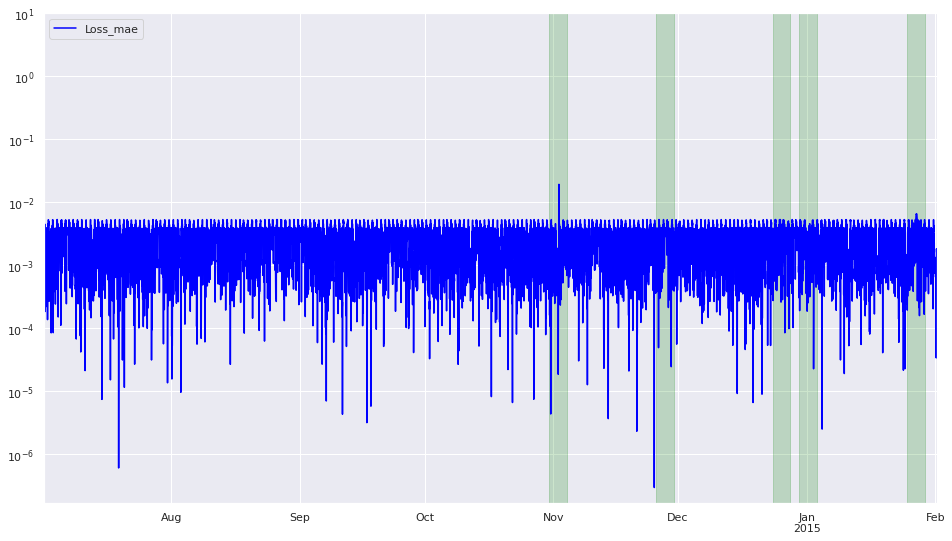

In [91]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (30, 6))
gs1 = gridspec.GridSpec(3, 1)
gs1.update(wspace=0.025, hspace=0.05) 

ax1 = plt.subplot(gs1[1:3])

ax1.plot(range(len(X)),X)
ax2 = plt.subplot(gs1[1:3])
ax2.plot(range(len(X_pred)), X_pred)
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)
    
ax3 = plt.subplot(gs1[1:3])
scored_all.plot(logy=True,  figsize=(16,9), ylim=[-1e-2,1e1], color=['blue','red'])
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

# i = 0
# for x in X:
#     if len(x) == 2:
#         ax1 = plt.subplot(gs1[i:i+2])
#         for line in x:
#             t = range(len(line))
#             ax1.plot(t, line)
#         i+=1
#     else:
#         ax1 = plt.subplot(gs1[i])
#         t = range(len(line))
#         ax1.plot(t, x, color='tab:red')

#     i+=1
#     plt.xlim(t[0], t[-1])
#     plt.yticks(size=22)
#     plt.axis('on')
#     ax1.set_xticklabels([])

plt.show()


# tadGAN 결과 재도출

In [83]:
X = np.load('result/tadGAN_X.npy')
X_gen = np.load('result/tadGAN_X_gen.npy')
final = np.load('result/tadGAN_final.npy')

In [89]:
def bokwon(y, y_hat, step_size):
    true = [item[0] for item in y]
    for item in y[-1][1:]:
        true.append(item)

    predictions = []
    pred_length = y_hat.shape[1]
    num_errors = y_hat.shape[1] + step_size * (y_hat.shape[0] - 1)

    for i in range(num_errors):
        intermediate = []
        for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
            intermediate.append(y_hat[i - j, j])
        if intermediate:
            predictions.append(np.median(np.asarray(intermediate), axis=0))

    true = np.asarray(true)
    predictions = np.asarray(predictions)
    return true, predictions

r_X, r_X_pred = bokwon(X, X_gen, 1)
print(r_X.shape)
print(r_X_pred.shape)

(10320, 1)
(10320, 1)


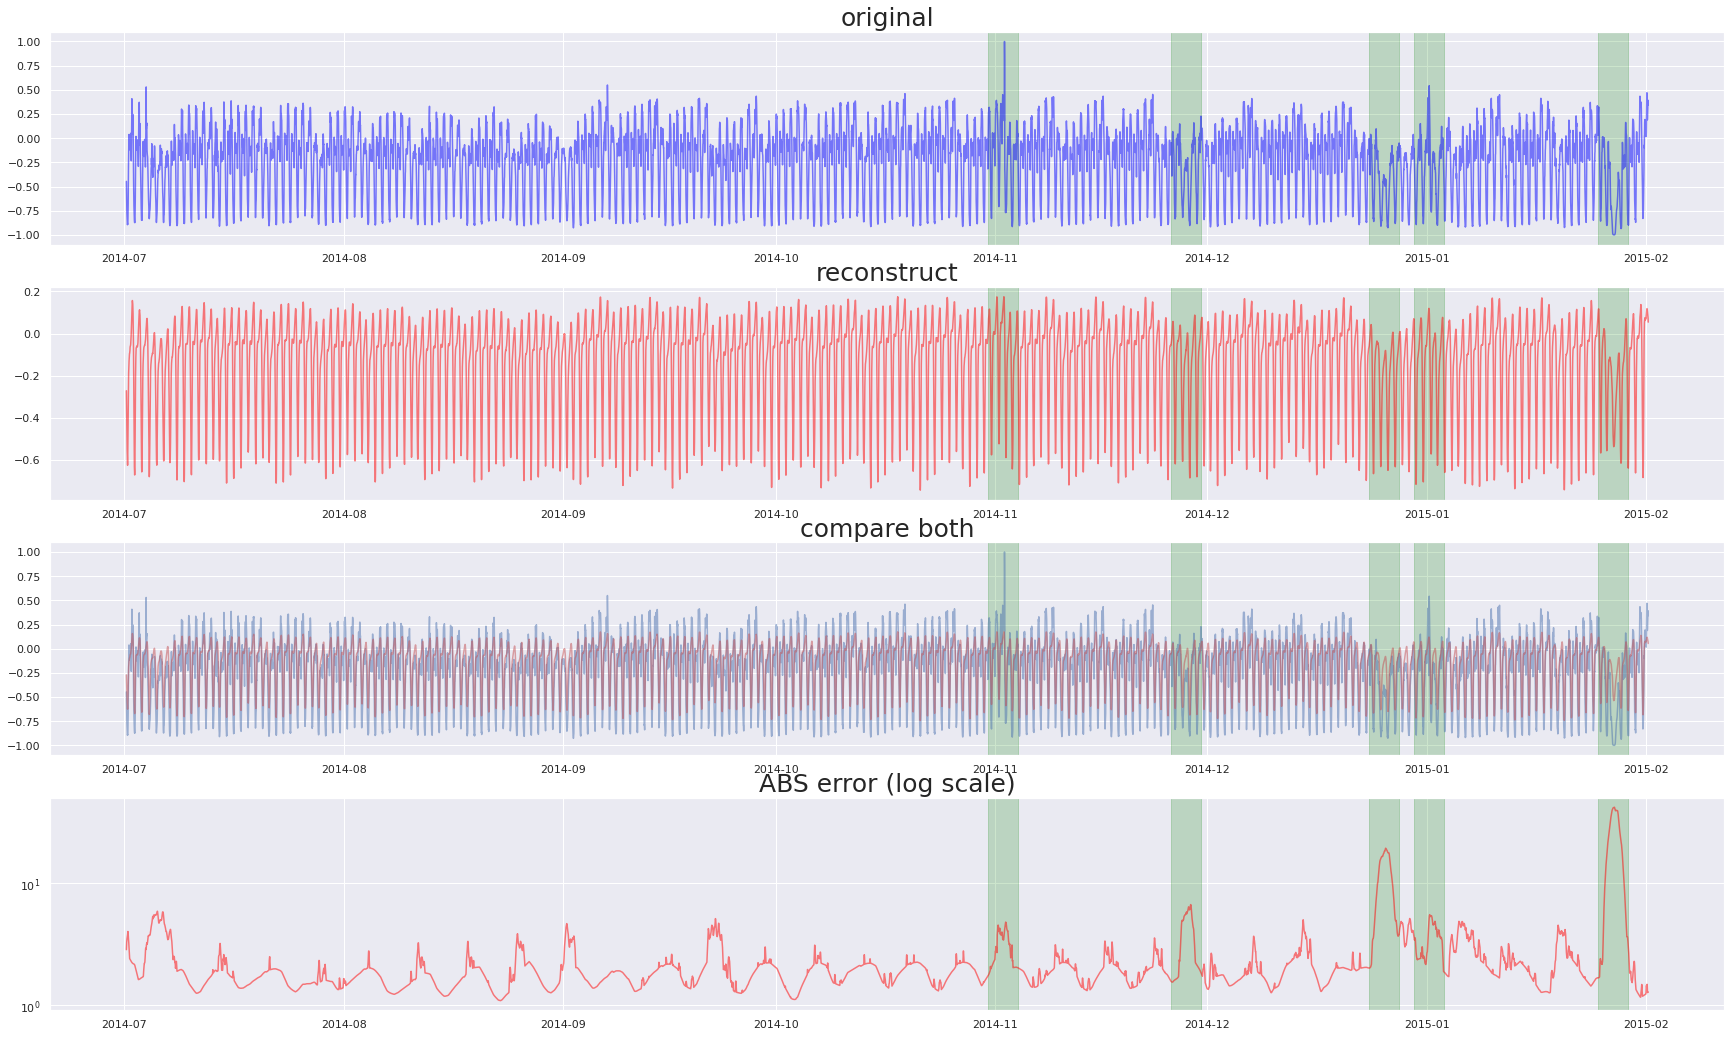

In [90]:
plt.figure(figsize = (30, 18))
# plt.ylim(-1,1)
plt.subplot(4,1,1)
plt.title('original', size=25)
plt.plot(All.index, r_X, alpha=0.5, color='blue')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,2)
plt.title('reconstruct', size=25)
plt.plot(All.index, r_X_pred, alpha=0.5, color='red')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)


plt.subplot(4,1,3)
plt.plot(All.index, r_X, 'b', All.index, r_X_pred, 'r', alpha=0.5)
plt.title('compare both', size=25)
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)

plt.subplot(4,1,4)
plt.title('ABS error (log scale)', size=25)
plt.plot(All.index, final, alpha=0.5, color='red')
plt.yscale('log')
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)